# Задание — написать алгоритмы для решения задачи о минимальном остовном дереве и сравнить их работу.

Целью каждой лабораторной работы является реализация, сравнение и анализ двух алгоритмов, решающих одну и ту же задачу. Задание считается выполненным после представления программы, тестов по задаче и беседы по работе. Программа по каждой лабораторной работе должна предусматривать пользовательский ввод данных для небольших значений параметров (тут желательна визуализация входных данных и ответа по задаче), а также предусматривать автоматическую генерацию растущих входных данных и построение графика производительности в зависимости от параметра.

Алгоритм Прима: сначала берётся произвольная вершина и находится ребро, инцидентное данной вершине и обладающее наименьшей стоимостью. Найденное ребро и соединяемые им две вершины образуют дерево. Затем, рассматриваются рёбра графа, один конец которых — уже принадлежащая дереву вершина, а другой — нет; из этих рёбер выбирается ребро наименьшей стоимости. Выбираемое на каждом шаге ребро присоединяется к дереву. Рост дерева происходит до тех пор, пока не будут исчерпаны все вершины исходного графа.

## Настройки/гиперпараметры/импорты

In [237]:
import numpy as np # для быстрой работы с массивами
import matplotlib.pyplot as plt # для вывода графиков
import networkx as nx # для построения графов
import random # для случайной генерации графов
import time # для подсчёта времени выполнения

In [118]:
random_state = 42 # для генератора случайных чисел

## Вспомогательные функции

In [195]:
def print_graph(adj_matrix: np.array, edges=None, random_state=random_state) -> None:
    """
    функция для построения графа\n
    Parameters:
        * adj_matrix - матрица смежности
        * edges - рёбра, что надо выделить
        * random_state - случайное число для отображения графа (положение вершин в пространстве)\n
    Returns:
        * None (выводит график)
    """
    plt.figure(figsize=(10,10)) # задание размера графика
    
    G = nx.from_numpy_array(adj_matrix) # создаём объект графа из списка смежности
    pos = nx.spring_layout(G, seed=random_state) # задание позиций вершин графа для графика (seed задаёт расположение вершин на графике)

    if edges is not None:
        for edge in edges: # идём по переданным рёбрам
            G[edge[0]][edge[1]]["color"] = '#1f78b4' # ребро будет синим
            G[edge[0]][edge[1]]["width"] = 3 # ширина ребра

    colors = [] # массив для цветов рёбер
    widths = [] # массив для ширины рёбер
    for edge in G.edges(): # идм по рёбрам
        if "color" in G[edge[0]][edge[1]]: # проверяем, есть ли у них цвет
            colors.append(G[edge[0]][edge[1]]["color"]) # если есть — добавляем его в массив цветов рёбер
        else: # иначе - цвет ребра будет чёрный
            colors.append("black")

        if "width" in G[edge[0]][edge[1]]: # проверяем, есть ли у них ширина
            widths.append(G[edge[0]][edge[1]]["width"]) # если есть — добавляем её в массив ширины рёбер
        else: # иначе - ширина ребра будет единичной
            widths.append(1)
        
    nx.draw_networkx(G, pos, width=widths, edge_color=colors) # построение графа, pos - позиции вершин графа, width - ширина ребра, edge_color - цвет рёбер
    labels = nx.get_edge_attributes(G, name='weight') # взятие атрибутов рёбер (веса) и запись его в переменную labels (будет идти названием ребёр)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels) # добавление подписей на рёбра

    plt.show() # вывод графа

In [206]:
def get_adj_matrix(path: str) -> np.array: # функция для ручного ввода (с помощью файла)
    """
    Функция для ручного ввода данных (с помощью файла)\n
    Parameters:
        * path - путь до файла с таблицей смежности\n
    Returns:
        * np.array (таблица смежности)
    """
    adj_matrix = []
    with open(path, "r") as f: # открываем файл для чтения
        for line in f: # идём по строкам в файле
            adj_matrix.append([int(x) for x in line.split()]) # добавляем данные в матрицу смежности
    return np.array(adj_matrix) # возвращаем сконвертированную в np.array матрицу смежности 

In [242]:
def generate_graph(nodes_count=10) -> np.array:
    """
    Функция для генерации растущих входных данных\n
    Parameters:
        * nodes_count - число вершин в создаваемом графе\n
    Returns:
        * np.array (таблица смежности)
    """
    G = nx.complete_graph(nodes_count) # генерируем полносвязный граф
    adj_matrix = nx.to_numpy_array(G) # получаем матрицу смежности

    for i in range(nodes_count): # идём по элементам матрицы смежности
        for j in range(nodes_count): # идём по элементам матрицы смежности
            if i != j: # пропускаем диагональные элементы
                adj_matrix[i][j] = random.randint(0,100) # задаём случайный вес рёбрам от 0 до 100

    return adj_matrix

In [ ]:
def performance_measurement(init_size=10, max_size=1000, step=10, average=3) -> None:
    """
    Функция для построения графика производительности\n
    Parameters:
        * init_size - начальный размер графа
        * max_size - максимальное число вершин в графе
        * step - на сколько вершин увеличивать графы
        * average - число запусков с одинаковой генерацией для усреднения времени\n
    Returns:
        * None (строит графики производительности)
    """
    time = {"with labels": [], "with Fibonacci heap": []} # словарь для сохранения времени
    for nodes_count in range(init_size, max_size+1, step): # рассматриваем графы с числом вершин от init_size до max_size с шагом в step
        adj_matrix = generate_graph(nodes_count=nodes_count) # генерируем граф (матрицу смежности)

        time_start = time.perf_counter() # замеряем текущее время
        for i in range(average): # делаем несколько запусков для усреднения времени
            alg_Prim_with_label(adj_matrix) # запускаем алгоритм
        time["with labels"].append((time.perf_counter() - time_start)/average) # сохраняем полученное время
        
        time_start = time.perf_counter() # замеряем текущее время
        for i in range(average): # делаем несколько запусков для усреднения времени
            alg_Prim_with_Fibonacci_heap(adj_matrix) # запускаем алгоритм
        time["with Fibonacci heap"].append((time.perf_counter() - time_start)/average) # сохраняем полученное время
    

    plt.figure(figsize=(10,10)) # задание размера графика
    plt.title('Время работы алгоритмов в зависимости от размера графа') # название графика
    plt.plot(time["with labels"], "b", label='алгоритм Прима с метками') # построение графика времени выполнения алгоритма на метках
    plt.plot(time["with Fibonacci heap"], "r", label='алгоритм Прима с Фибоначчиевой кучей') # построение графика времени выполнения алгоритма на Фибоначчиевой куче
    plt.legend() # вывод названий графиков
    plt.show() # вывод графика
        

## 1) Алгоритм Прима на метках

В синий цвет окрашивается произвольная вершина графа. Далее на каждой итерации для текущего синего дерева вычисляется минимальное допустимое ребро (только один конец которого окрашен в синий). Это ребро и его неокрашенный конец красятся в синий цвет. 

In [142]:
# def alg_Prim_with_label(G: nx.Graph): # на вход — граф
def alg_Prim_with_label(adj_matrix: np.array) -> list: # на вход — список смежности связного графа (веса рёбер между вершинами, 0 - ребра нет)
# подготовка — O(n^2) из-за поиска соседей (но это, вообще говоря, можно вынести из алгоритма и передавать соседей как параметр функции)
    nodes_count = adj_matrix.shape[0] # число вершин в графе

    neighbors = [] # список окрестностей вершин
    for row in adj_matrix: # идём по строкам (row - список, в котором указаны веса рёбер до соседей)
        neighbors.append([]) # заготавливаем место для соседей рассматриваемой вершины
        for node, weight in enumerate(row): # рассматриваем в строке все вершины с их весом
            if weight > 0: # если вес больше нуля — есть ребро
                neighbors[-1].append(node) # добавляем вершину в окрестность

    labels = np.zeros(shape=nodes_count) # создаём массив меток (размера числа вершин), пока все вершины считаются неокрашенными (метка - ноль)

    dists = np.full(shape=nodes_count, fill_value=np.inf) # список с минимальными путями (размера числа вершин), где на i-ой позиции длина ребра от вершины i до синего дерева (изначально заполнен inf)

    nodes_in_tree = np.full(shape=nodes_count, fill_value=nodes_count) # массив вторых концов рёбер, находящихся в синем дереве, где на i-ой позиции находится номер ближайшей вершины в синем дереве для i, нужен для быстрого добавления рёбер в solution (изначально заполнен недопустимым значением — на 1 больше числа вершин)

    solution = [] # массив для решения (список рёбер)

# начальная инициализация — O(n) из-за графа, в котором начальная вершина связана со всеми
    labels[0] = 1 # ставим первой вершине (идёт под индексом 0) метку окрашивания, то есть она теперь одновершинное окрашенное дерево
    for node in neighbors[0]: # идём по вершинам-соседям стартовой вершины
        dists[node] = adj_matrix[0, node] # обновляем их дистанцию до синего дерева
        nodes_in_tree[node] = 0 # обновляем вторые концы рёбер (стартовая вершина для них ближайшая в окрашенном дереве)
    
# добавление рёбер (вершин) в окрашенное синее дерево — O(n^2) из-за n-1 раза поиска вершины с наименьшим расстоянием за O(n) и обновлений для соседей за, в худшем случае, O(n) 
    while (len(solution)) < nodes_count-1: # итерируемся, пока рёбер не будет на 1 меньше, чем вершин в графе (по определению остовного дерева)
        possible_nodes = np.where(labels == 0)[0] # список возможных вершин для добавления (не окрашенных)
        node_to_add = possible_nodes[dists[possible_nodes].argmin()] # ищем ближайшую вершину к синему дереву, что будем добавлять 
        # dists[possible_nodes].argmin() - вернёт позицию вершины с минимальным расстоянием до синего дерева, однако такая позиция может быть смещена, так как мы оставили только те вершины, у которых нет метки окрашивания (possible_nodes)
        # поэтому берём настоящую вершину из possible_nodes по найденному в dists[possible_nodes].argmin() индексу

        labels[node_to_add] = 1 # ставим метку окрашивания выбранной вершине
        solution.append((nodes_in_tree[node_to_add], node_to_add)) # добавляем ребро в решение, где nodes_in_tree[node_to_add] - конец ребра, что уже в синем дереве
        for node in neighbors[node_to_add]: # идём по вершинам-соседям добавляемой в дерево вершины node_to_add
            if labels[node] == 0: # если соседняя вершина ещё не окрашена
                if dists[node] > adj_matrix[node_to_add, node]: # если расстояние от соседней вершины до дерева уменьшится при добавлении node_to_add в дерево
                    dists[node] = adj_matrix[node_to_add, node] # обновляем расстояние до синего дерева
                    nodes_in_tree[node] = node_to_add # изменяем второй конец ребра в окрашенном дереве

    return solution # возвращаем полученное оптимальное решение (список окрашенных синих рёбер)


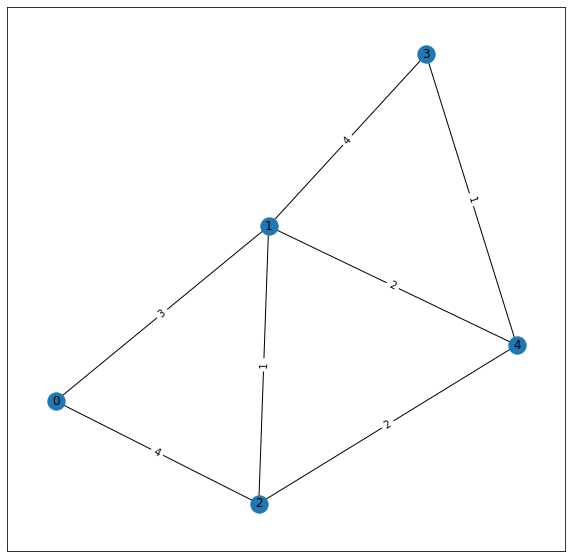

In [252]:
# adj_matrix = np.array([[0, 3, 4, 0, 0], [3, 0, 1, 4, 2], [4, 1, 0, 0, 2], [0, 4, 0, 0, 1], [0, 2, 2, 1, 0]]) # список смежности — веса ребёр (0 - ребра нет)
adj_matrix = get_adj_matrix("data/input1.txt") # считывание матрицы смежности
print_graph(adj_matrix) # вывод начального графа

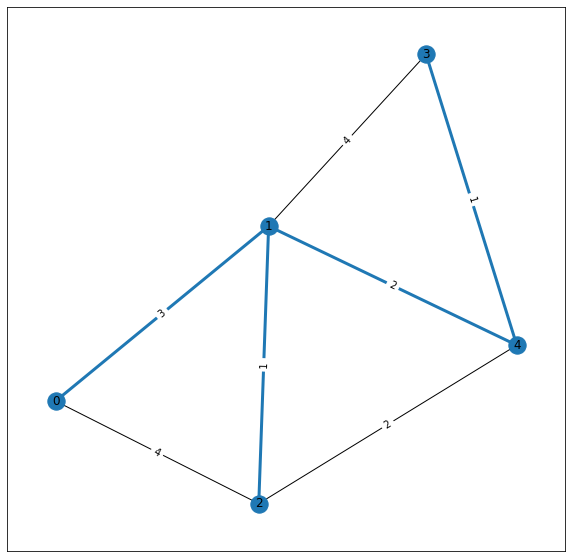

In [194]:
edges_prim_with_labels = alg_Prim_with_label(adj_matrix) # подсчёт остовного дерева алгоритмом Прима с метками
print_graph(adj_matrix=adj_matrix, edges=edges_prim_with_labels) # вывод остовного дерева

## 2) Алгоритм Прима на фибоначчиевой куче

Идея: хранить расстояния до синего дерева только для неокрашенных вершин в формате приоритетной очереди (с использованием фибоначчиевой кучи).

In [ ]:
class FibonacciHeap:

    def (self):
        

In [ ]:
def alg_Prim_with_Fibonacci_heap(adj_matrix: np.array) -> list: # на вход — список смежности связного графа (веса рёбер между вершинами, 0 - ребра нет)